# How Kernel work in Convolution

Reference: 
- [https://github.com/chokkan/deeplearning/blob/master/notebook/convolution.ipynb](https://github.com/chokkan/deeplearning/blob/master/notebook/convolution.ipynb)
- [https://github.com/udacity/deep-learning-v2-pytorch/blob/master/convolutional-neural-networks/conv-visualization/conv_visualization.ipynb](https://github.com/udacity/deep-learning-v2-pytorch/blob/master/convolutional-neural-networks/conv-visualization/conv_visualization.ipynb)



This notebook demonstrates *convolution matrix* (aka. *kernel*). See: https://en.wikipedia.org/wiki/Kernel_(image_processing)

### Load a sample image (via Pillow: a fork of Python Image Library (PIL))

In [1]:
from PIL import Image

In [2]:
img = Image.open(urllib.request.urlopen('https://sketchok.com/images/articles/06-anime/002-one-piece/26/16.jpg'))
img.thumbnail((256,256), Image.LANCZOS) # Resize to half to reduce the size of this notebook.

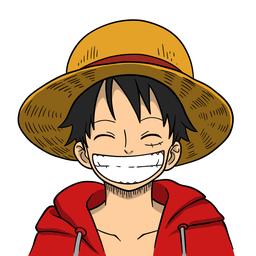

In [3]:
img

### Convert the image into torch.tensor

In [4]:
import torch, torchvision
from torchvision import transforms
from torch import nn

Define utility functions to bridge images and tensors.

In [5]:
to_tensor = transforms.Compose([
   transforms.Grayscale(),  # Convert image to grayscale.
   transforms.ToTensor()    # Converts a PIL Image in the range [0, 255] to a torch.FloatTensor in the range [0.0, 1.0].
])

to_pil = transforms.Compose([
    transforms.ToPILImage()
])

Convert the PIL image object into a torch tensor.

In [6]:
input = to_tensor(img)

The shape of `input` is (channel, width, height).

In [7]:
input.shape

torch.Size([1, 256, 256])

In [8]:
input

tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]]])

Confirm that we can convert back to the original image from the tensor.

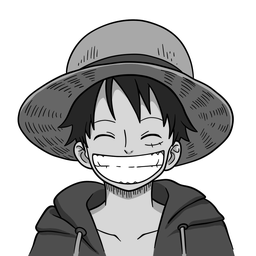

In [9]:
to_pil(input)

## Convolution layer

2D convolution over an input image:

+ `in_channels = 1`: an input is a grayscale image
+ `out_channels = 1`: an output is a grayscale image
+ `kernel_size = (3, 3)`: the kernel (filter) size is 3 x 3
+ `stride = 1`: the stride for the cross-correlation is 1
+ `padding = 1`: zero-paddings on both sides for 1 point for each dimension
+ `bias = False`: no bias parameter (for simplicity)

In [10]:
conv = nn.Conv2d(1, 1, (3, 3), stride=1, padding=1, bias=False)

The code below does not work because the convolution layer requires the dimension for batch.

In [11]:
conv(input)

tensor([[[ 0.5206,  1.0589,  1.0589,  ...,  1.0589,  1.0589,  1.0035],
         [ 0.2834,  0.8386,  0.8386,  ...,  0.8386,  0.8386,  0.8169],
         [ 0.2834,  0.8386,  0.8386,  ...,  0.8386,  0.8386,  0.8169],
         ...,
         [ 0.2834,  0.8386,  0.8386,  ...,  0.8386,  0.8386,  0.8169],
         [ 0.2834,  0.8386,  0.8386,  ...,  0.8386,  0.8386,  0.8169],
         [-0.1154,  0.1272,  0.1272,  ...,  0.1272,  0.1272,  0.2769]]],
       grad_fn=<SqueezeBackward1>)

We need to insert a dimension for a batch at dim=0.

In [12]:
input = input.unsqueeze(0)

In [13]:
input.shape

torch.Size([1, 1, 256, 256])

In [14]:
output = conv(input)

Setting `padding=1` in the convolution layer, we obtain an image of the same size.

In [15]:
output.shape

torch.Size([1, 1, 256, 256])

We need to remove the first dimension before converting to a PIL object.

In [16]:
output.data.squeeze(dim=0).shape

torch.Size([1, 256, 256])

Display the output from the convolution layer by converting `output` to a PIL object.

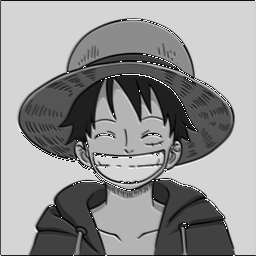

In [17]:
to_pil(output.data.squeeze(dim=0))

Clip every value in the output tensor within the range of [0, 1].

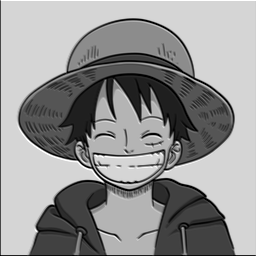

In [18]:
to_pil(torch.clamp(output, 0, 1).data.squeeze(dim=0))

Utility function to show two images in a row.

In [19]:
def display(img1, img2):
    im1 = to_pil(torch.clamp(img1, 0, 1).data.squeeze(dim=0))
    im2 = to_pil(torch.clamp(img2, 0, 1).data.squeeze(dim=0))
    dst = Image.new('RGB', (im1.width + im2.width, im1.height))
    dst.paste(im1, (0, 0))
    dst.paste(im2, (im1.width, 0))
    return dst

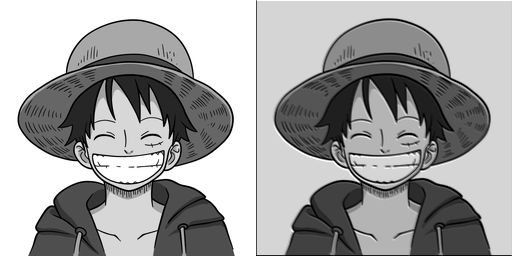

In [20]:
display(input, output)

In [21]:
conv.weight.data

tensor([[[[ 0.0169, -0.2035, -0.0337],
          [ 0.2257,  0.2378, -0.1160],
          [ 0.3126,  0.2274,  0.1714]]]])

In [22]:
conv.weight.shape

torch.Size([1, 1, 3, 3])

### Identity

In [23]:
conv.weight.data = torch.tensor([[[
    [0., 0., 0.],
    [0., 1, 0.],
    [0., 0., 0.],
]]])

In [24]:
conv.weight.data

tensor([[[[0., 0., 0.],
          [0., 1., 0.],
          [0., 0., 0.]]]])

In [25]:
output = conv(input)

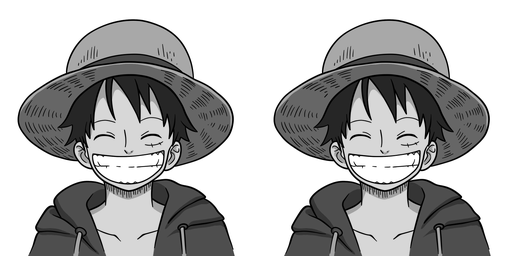

In [26]:
display(input, output)

### Brighten

tensor([[[[0.0000, 0.0000, 0.0000],
          [0.0000, 1.5000, 0.0000],
          [0.0000, 0.0000, 0.0000]]]])


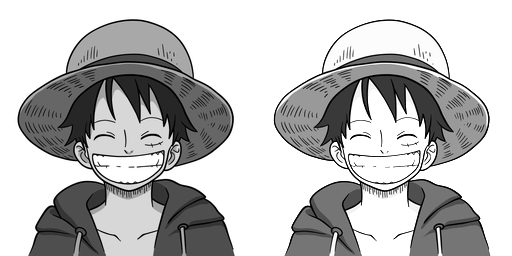

In [27]:
conv.weight.data = torch.tensor([[[
    [0., 0., 0.],
    [0., 1.5, 0.],
    [0., 0., 0.],
]]])
print(conv.weight.data)
output = conv(input)
display(input, output)

### Darken

tensor([[[[0.0000, 0.0000, 0.0000],
          [0.0000, 0.5000, 0.0000],
          [0.0000, 0.0000, 0.0000]]]])


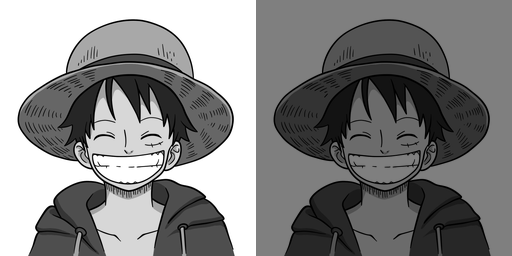

In [28]:
conv.weight.data = torch.tensor([[[
    [0., 0., 0.],
    [0., 0.5, 0.],
    [0., 0., 0.],
]]])
print(conv.weight.data)
output = conv(input)
display(input, output)

### Box blur

tensor([[[[0.1111, 0.1111, 0.1111],
          [0.1111, 0.1111, 0.1111],
          [0.1111, 0.1111, 0.1111]]]])


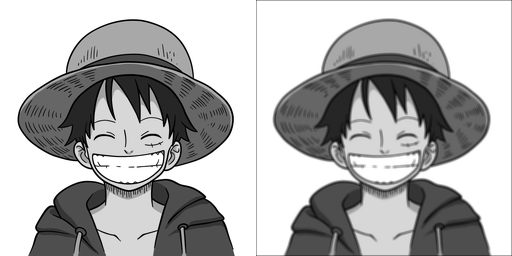

In [29]:
conv.weight.data = torch.ones((1, 1, 3,3), dtype=torch.float) / 9.
print(conv.weight.data)
output = conv(input)
display(input, output)

### Gaussian blur

tensor([[[[0.0625, 0.1250, 0.0625],
          [0.1250, 0.2500, 0.1250],
          [0.0625, 0.1250, 0.0625]]]])


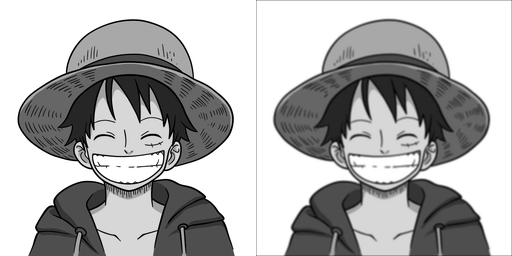

In [30]:
conv.weight.data = torch.tensor([[[
    [1., 2., 1.],
    [2., 4., 2.],
    [1., 2., 1.],
]]])/16.
print(conv.weight.data)
output = conv(input)
display(input, output)

### Sharpen

tensor([[[[ 0., -1.,  0.],
          [-1.,  5., -1.],
          [ 0., -1.,  0.]]]])


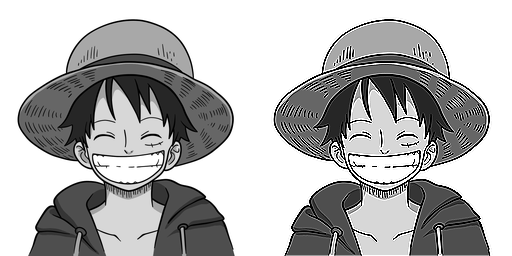

In [31]:
conv.weight.data = torch.tensor([[[
    [0., -1., 0.],
    [-1., 5., -1.],
    [0., -1., 0.],
]]])
print(conv.weight.data)
output = conv(input)
display(input, output)

tensor([[[[ 0., -2.,  0.],
          [-2., 10., -2.],
          [ 0., -2.,  0.]]]])


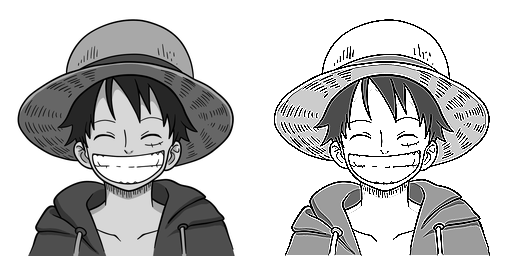

In [32]:
conv.weight.data = torch.tensor([[[
    [0., -2., 0.],
    [-2., 10., -2.],
    [0., -2., 0.],
]]])
print(conv.weight.data)
output = conv(input)
display(input, output)

### Edge detection

tensor([[[[ 0.,  1.,  0.],
          [ 1., -4.,  1.],
          [ 0.,  1.,  0.]]]])


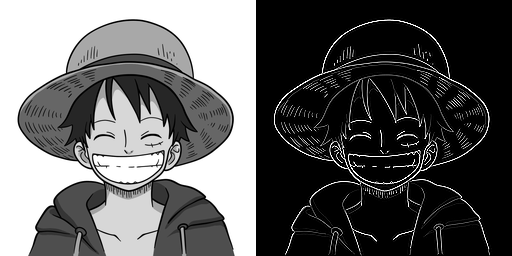

In [33]:
conv.weight.data = torch.tensor([[[
    [0., 1., 0.],
    [1., -4., 1.],
    [0., 1., 0.],
]]])
print(conv.weight.data)
output = conv(input)
display(input, output)

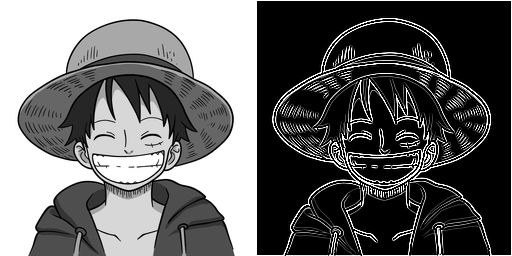

In [34]:
conv.weight.data = torch.tensor([[[
    [-1., -1., -1.],
    [-1., 8., -1.],
    [-1., -1., -1.],
]]])
output = conv(input)
display(input, output)

# Vizualize the Convolutional Layer

Let's also visualize the convolutional layer, to gain some intuitions: 

In this example, *we* are defining four filters that are applied to an input image by initializing the **weights** of a convolutional layer, but a trained CNN will learn the values of these weights.

<img src='images/conv_layer.gif' height=60% width=60% />

Import the image

In [35]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

# TODO: Feel free to try out your own images here by changing img_path
# to a file path to another image on your computer!
img_path = 'data/udacity_sdc.png'

# load color image 
bgr_img = cv2.imread(img_path)
# convert to grayscale
gray_img = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2GRAY)

# normalize, rescale entries to lie in [0,1]
gray_img = gray_img.astype("float32")/255

# plot image
plt.imshow(gray_img, cmap='gray')
plt.show()

ModuleNotFoundError: No module named 'matplotlib.backends.registry'

Define and visualize the filters

In [ ]:
import numpy as np

## TODO: Feel free to modify the numbers here, to try out another filter!
filter_vals = np.array([[-1, -1, 1, 1], [-1, -1, 1, 1], [-1, -1, 1, 1], [-1, -1, 1, 1]])

print('Filter shape: ', filter_vals.shape)


In [ ]:
# Defining four different filters, 
# all of which are linear combinations of the `filter_vals` defined above

# define four filters
filter_1 = filter_vals
filter_2 = -filter_1
filter_3 = filter_1.T
filter_4 = -filter_3
filters = np.array([filter_1, filter_2, filter_3, filter_4])

# For an example, print out the values of filter 1
print('Filter 1: \n', filter_1)

In [ ]:
# visualize all four filters
fig = plt.figure(figsize=(10, 5))
for i in range(4):
    ax = fig.add_subplot(1, 4, i+1, xticks=[], yticks=[])
    ax.imshow(filters[i], cmap='gray')
    ax.set_title('Filter %s' % str(i+1))
    width, height = filters[i].shape
    for x in range(width):
        for y in range(height):
            ax.annotate(str(filters[i][x][y]), xy=(y,x),
                        horizontalalignment='center',
                        verticalalignment='center',
                        color='white' if filters[i][x][y]<0 else 'black')

**Define the Convolutional layer**

The various layers that make up any neural network are documented, [here](http://pytorch.org/docs/stable/nn.html). For a convolutional neural network, we'll start by defining a:
* Convolutional layer

Initialize a single convolutional layer so that it contains all your created filters. Note that you are not training this network; you are initializing the weights in a convolutional layer so that you can visualize what happens after a forward pass through this network!

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
    
# define a neural network with a single convolutional layer with four filters
class Net(nn.Module):
    
    def __init__(self, weight):
        super(Net, self).__init__()
        # initializes the weights of the convolutional layer to be the weights of the 4 defined filters
        k_height, k_width = weight.shape[2:]
        # assumes there are 4 grayscale filters
        self.conv = nn.Conv2d(1, 4, kernel_size=(k_height, k_width), bias=False)
        self.conv.weight = torch.nn.Parameter(weight)

    def forward(self, x):
        # calculates the output of a convolutional layer
        # pre- and post-activation
        conv_x = self.conv(x)
        activated_x = F.relu(conv_x)
        
        # returns both layers
        return conv_x, activated_x
    
# instantiate the model and set the weights
weight = torch.from_numpy(filters).unsqueeze(1).type(torch.FloatTensor)
model = Net(weight)

# print out the layer in the network
print(model)

Visualize the output of each layer


In [ ]:
# helper function for visualizing the output of a given layer
# default number of filters is 4
def viz_layer(layer, n_filters= 4):
    fig = plt.figure(figsize=(20, 20))
    
    for i in range(n_filters):
        ax = fig.add_subplot(1, n_filters, i+1, xticks=[], yticks=[])
        # grab layer outputs
        ax.imshow(np.squeeze(layer[0,i].data.numpy()), cmap='gray')
        ax.set_title('Output %s' % str(i+1))

In [ ]:
# plot original image
plt.imshow(gray_img, cmap='gray')

# visualize all filters
fig = plt.figure(figsize=(12, 6))
fig.subplots_adjust(left=0, right=1.5, bottom=0.8, top=1, hspace=0.05, wspace=0.05)
for i in range(4):
    ax = fig.add_subplot(1, 4, i+1, xticks=[], yticks=[])
    ax.imshow(filters[i], cmap='gray')
    ax.set_title('Filter %s' % str(i+1))

    
# convert the image into an input Tensor
gray_img_tensor = torch.from_numpy(gray_img).unsqueeze(0).unsqueeze(1)

# get the convolutional layer (pre and post activation)
conv_layer, activated_layer = model(gray_img_tensor)

# visualize the output of a conv layer
viz_layer(conv_layer)

In [ ]:
viz_layer(activated_layer)